<h1 align="center" style="text-align:center">Approach 3</h1>


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.fftpack import fft
import os

In [2]:
folder_path = 'Kaggle competition dataset\data\person_3'

def make_data(folder_path):
    i = 0
    for root,dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith('.csv'):
                    csv_path = os.path.join(root , file)
                    step_path = os.path.join(root, file[7:] + '.stepMixed')
                   
                    if os.path.exists(step_path):
                        i += 1
                
                        df = pd.read_csv(csv_path)
                        step = pd.read_csv(step_path,header = None)
                       
                        df['STEP'] = '0'
                       
                       
                         # loop to delete the the first rows of the start index
                        for start_removed in step.iloc[0,0:1]:
                            #print(start_removed)
                            for value in range(0,start_removed):
                                #print(value)
                                df.at[value, 'STEP'] = 'start_Remove'
                        for end_removed in step.iloc[-1 ,1:]:
                            #print(end_removed)
                            #break
                            for value in range(end_removed, len(df)):
                                df.at[value,'STEP'] = 'end_Remove'
                       
                           
                        # labelling of the signals starts here
                        for start in step.iloc[0:, 0]:
                            for start_index in range(start , start+10):
                                df.at[start_index,'STEP'] = 1 # start
                        for end in step[1]:
                            for end_index in range(end-10,end+1):
                                df.at[end_index ,'STEP'] = 2 # end
                                      
                        df = df[~df['STEP'].isin(['start_Remove','end_Remove'])]
                        df.reset_index(inplace=True,drop=True)
                       
    print(f"Total number of files processed : {i}")
    return df

In [3]:
df = make_data(folder_path)
df

Total number of files processed : 1


,Activity,AccelX_5,AccelY_5,AccelZ_5,GyroX_5,GyroY_5,GyroZ_5,STEP
0,0,0.793482,4.819149,8.591328,0.194402,0.111826,-0.146028,1
1,0,0.767883,4.944201,8.592199,0.158926,0.173983,-0.142780,1
2,0,0.705722,5.140792,8.896264,0.102394,0.241190,-0.128025,1
3,0,0.629672,5.151704,9.259640,0.053802,0.201690,-0.127561,1
4,0,0.681415,5.215279,9.326802,0.039253,0.145595,-0.143680,1
...,...,...,...,...,...,...,...,...
30006,1,0.792035,3.813622,8.005259,0.559066,0.074544,0.408358,2
30007,0,0.840591,4.129035,7.988197,0.439840,0.049318,0.459895,2
30008,0,0.845066,4.253616,8.005763,0.341815,0.014580,0.493618,2
30009,0,0.929462,4.378284,7.731349,0.277544,-0.005427,0.510498,2


In [4]:
# # Initialize "start" and "end" columns with 0
df['start'] = 0
df['end'] = 0

# Set values based on the "step" column
df.loc[df['STEP'] == 1, 'start'] = 1
df.loc[df['STEP'] == 2, 'end'] = 1
df

,Activity,AccelX_5,AccelY_5,AccelZ_5,GyroX_5,GyroY_5,GyroZ_5,STEP,start,end
0,0,0.793482,4.819149,8.591328,0.194402,0.111826,-0.146028,1,1,0
1,0,0.767883,4.944201,8.592199,0.158926,0.173983,-0.142780,1,1,0
2,0,0.705722,5.140792,8.896264,0.102394,0.241190,-0.128025,1,1,0
3,0,0.629672,5.151704,9.259640,0.053802,0.201690,-0.127561,1,1,0
4,0,0.681415,5.215279,9.326802,0.039253,0.145595,-0.143680,1,1,0
...,...,...,...,...,...,...,...,...,...,...
30006,1,0.792035,3.813622,8.005259,0.559066,0.074544,0.408358,2,0,1
30007,0,0.840591,4.129035,7.988197,0.439840,0.049318,0.459895,2,0,1
30008,0,0.845066,4.253616,8.005763,0.341815,0.014580,0.493618,2,0,1
30009,0,0.929462,4.378284,7.731349,0.277544,-0.005427,0.510498,2,0,1


In [5]:
Step_label = df[['start', 'end']].values
Step_label

array([[1, 0],
       [1, 0],
       [1, 0],
       ...,
       [0, 1],
       [0, 1],
       [0, 1]], dtype=int64)

### Data Pre-Processing


**1. Butterworth filter is a type of linear filter commonly used in digital signal processing produces flat frequency response.**

**2. Therefore Used to preprocess the data by removing noise but sometimes it has been known to suffer from information loss when producing flat frequencies.**

**3. Although MinMax scaler scales between the range of 0 and 1 yet it may also miss out on some features during feature engineering**


In [6]:
from scipy.signal import butter, lfilter # for digital signal processing
from sklearn.preprocessing import MinMaxScaler # for scaling to numerical range

train_data = df.iloc[:, 1:7].values # accessing only the measurement readings of accelerometer and gyroscope

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs #Nyquist frequency
    normal_cutoff = cutoff / nyq #normalized cutoff frequency
    b, a = butter(order, normal_cutoff, btype='low', analog=False)  # to design a low pass digital butterworth filter
    return b, a # filter cooefficients

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)  #lfilter filters the noise from the readings
    return y

def rescale_data(data): # standardizing or normalizing data 
    scaler = MinMaxScaler(feature_range=(0, 1)) #set range of data transformation between 0 and 1
    reshaped_data = data.reshape(-1, 1) # column vector
    rescaled_data = scaler.fit_transform(reshaped_data) #rescales the reshaped data
    return rescaled_data.flatten() #flatten to 1 long array

# Separate the accelerometer and gyroscope data
train_data_acc = train_data[:, :3]
train_data_gyro = train_data[:, 3:]

# Perform FFT analysis for accelerometer and gyroscope data
fs_acc = 50.0 #sampling frequency
cutoff_acc = 3 # cut off frequencies below 3 are preserved
order_acc = 3 # affects the steepness of the roll-off and the filtering characteristics
fs_gyro = 50.0
cutoff_gyro = 2
order_gyro = 6

#FFT analysis on the filtered data to examine the frequency content and extract relevant features
fft_columns = [0, 1, 2]  # Columns for accelerometer and gyroscope data

for i, data_type in enumerate(['acc', 'gyro']):
    data = train_data_acc if data_type == 'acc' else train_data_gyro
    fs = fs_acc if data_type == 'acc' else fs_gyro
    cutoff = cutoff_acc if data_type == 'acc' else cutoff_gyro
    order = order_acc if data_type == 'acc' else order_gyro

    filtered_data = np.zeros_like(data)
    filtered_fft_data = np.zeros_like(data)

    for j, col in enumerate(fft_columns):
        # Filter the data
        filtered_data[:, j] = butter_lowpass_filter(data[:, j], cutoff, fs, order)
        # Perform FFT analysis on filtered data
        filtered_fft_data[:, j] = np.abs(fft(filtered_data[:, j])) #positive values are assigned here

    filtered_fft_data_rescaled = rescale_data(filtered_fft_data) #rescaling using minmax scaler
    filtered_data_rescaled = rescale_data(filtered_data) #rescaling using minmax scaler

    if data_type == 'acc':
        train_data_acc_filtered_rescaled = filtered_data_rescaled
        train_data_acc_filtered_fft_rescaled = filtered_fft_data_rescaled
    else:
        train_data_gyro_filtered_rescaled = filtered_data_rescaled
        train_data_gyro_filtered_fft_rescaled = filtered_fft_data_rescaled

# Concatenate the rescaled data
train_data_filtered_rescaled = np.concatenate((
    train_data_acc_filtered_rescaled.reshape(-1, 3),
    train_data_gyro_filtered_rescaled.reshape(-1, 3)
), axis=1)

train_data_filtered_rescaled = train_data_filtered_rescaled.astype('float32')
train_data_filtered_rescaled

array([[0.1749596 , 0.17598802, 0.17695166, 0.5115493 , 0.51154923,
        0.5115491 ],
       [0.17601728, 0.18248342, 0.18847461, 0.5115504 , 0.51154995,
        0.5115483 ],
       [0.17861375, 0.19877571, 0.21720996, 0.5115564 , 0.51155394,
        0.51154363],
       ...,
       [0.1867414 , 0.30792743, 0.65286744, 0.5306286 , 0.47121254,
        0.42194563],
       [0.19876981, 0.31689566, 0.6457898 , 0.53310305, 0.4728211 ,
        0.4299804 ],
       [0.20893686, 0.33036754, 0.6365603 , 0.5363601 , 0.47497287,
        0.43890542]], dtype=float32)

#### LSTM

**1. LSTM model of 2 LSTM layers, drop out layers and 2 fully connected layers.**

**2.We used LSTM here as it captures sequential data here step being in sequence very well but it is also computationally expensive and not very interpretable.**


Epoch: 1/15... Train Loss: 0.5894... Test Loss: 0.5001... Train Accuracy: 46.5463%... Test Accuracy: 56.8525%
Epoch: 2/15... Train Loss: 0.5770... Test Loss: 0.5834... Train Accuracy: 47.4426%... Test Accuracy: 47.3793%
Epoch: 3/15... Train Loss: 0.5728... Test Loss: 0.5409... Train Accuracy: 47.3793%... Test Accuracy: 47.3793%
Epoch: 4/15... Train Loss: 0.5422... Test Loss: 0.4952... Train Accuracy: 48.7288%... Test Accuracy: 47.2827%
Epoch: 5/15... Train Loss: 0.4528... Test Loss: 0.4524... Train Accuracy: 62.3438%... Test Accuracy: 60.5278%
Epoch: 6/15... Train Loss: 0.4135... Test Loss: 0.4352... Train Accuracy: 68.0984%... Test Accuracy: 68.5449%
Epoch: 7/15... Train Loss: 0.3935... Test Loss: 0.4107... Train Accuracy: 71.5704%... Test Accuracy: 67.6652%
Epoch: 8/15... Train Loss: 0.3979... Test Loss: 0.4247... Train Accuracy: 71.4338%... Test Accuracy: 69.7611%
Epoch: 9/15... Train Loss: 0.3750... Test Loss: 0.3826... Train Accuracy: 74.9459%... Test Accuracy: 75.2991%
Epoch: 10/

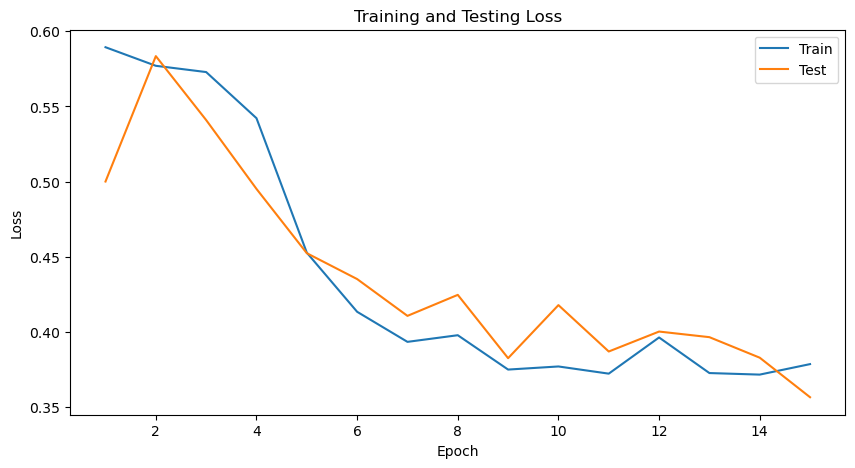

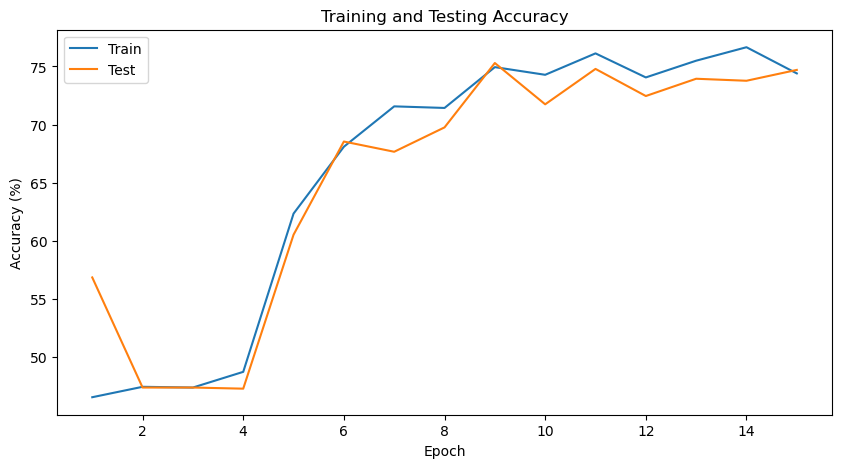

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm1 = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.dropout1 = nn.Dropout(0.3)#using drop out regularization with Percentage 0.5
        self.lstm2 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.dropout2 = nn.Dropout(0.3)#using drop out regularization with Percentage 0.5
        self.fc1 = nn.Linear(hidden_size, output_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        out, _ = self.lstm1(x)
        out = self.dropout1(out)
        out, _ = self.lstm2(out)
        out = self.dropout2(out)
        start = self.fc1(out)
        end = self.fc2(out)
        return start, end

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define the batch size
batch_size = 240
# Define the number of batches
num_batch = int(len(train_data_filtered_rescaled) / batch_size)

# Create data loaders
train_data = TensorDataset(torch.from_numpy(train_data_filtered_rescaled), torch.from_numpy(Step_label))
train_loader = DataLoader(train_data, shuffle=False, batch_size=batch_size)
test_data = TensorDataset(torch.from_numpy(train_data_filtered_rescaled), torch.from_numpy(Step_label))
test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size)

# LSTM model training
lstm = LSTM(6, 128, 1)
# Training epoch
epoch = 15
# Define the loss function
criterion = nn.BCEWithLogitsLoss()
# Define the optimizer
optimizer = optim.Adam(lstm.parameters(), lr=0.001)

# Lists to store training and testing values
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

# Train LSTM model
for e in range(epoch):
    running_loss = 0
    correct = 0
    total = 0

    # Training
    lstm.train()
    for i, (data, label) in enumerate(train_loader):
        data = data.to(device).float()
        label = label.to(device).float()
        label_start = label[:, 0].reshape(-1, 1)
        label_end = label[:, 1].reshape(-1, 1)
        optimizer.zero_grad()
        start, end = lstm(data)
        loss = 1 * (0.5 * criterion(start, label_start) + 0.5 * criterion(end, label_end))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # Calculate training accuracy
        predicted_start = torch.sigmoid(start) > 0.5
        predicted_end = torch.sigmoid(end) > 0.5
        correct += (predicted_start.eq(label_start) & predicted_end.eq(label_end)).sum().item()
        total += label_start.size(0)

    train_loss = running_loss / num_batch
    train_accuracy = 100 * correct / total

    # Testing
    lstm.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, label in test_loader:
            data = data.to(device).float()
            label = label.to(device).float()
            label_start = label[:, 0].reshape(-1, 1)
            label_end = label[:, 1].reshape(-1, 1)
            start, end = lstm(data)
            loss = 1 * (0.5 * criterion(start, label_start) + 0.5 * criterion(end, label_end))
            test_loss += loss.item()
            predicted_start = torch.sigmoid(start) > 0.5
            predicted_end = torch.sigmoid(end) > 0.5
            correct += (predicted_start.eq(label_start) & predicted_end.eq(label_end)).sum().item()
            total += label_start.size(0)

    test_loss /= len(test_loader)
    test_accuracy = 100 * (correct / total)

    # Append training and testing values
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    print('Epoch: {}/{}...'.format(e + 1, epoch),
          'Train Loss: {:.4f}...'.format(train_loss),
          'Test Loss: {:.4f}...'.format(test_loss),
          'Train Accuracy: {:.4f}%...'.format(train_accuracy),
          'Test Accuracy: {:.4f}%'.format(test_accuracy))

# Plotting the training and testing loss curves
plt.figure(figsize=(10, 5))
plt.plot(range(1, epoch+1), train_losses, label='Train')
plt.plot(range(1, epoch+1), test_losses, label='Test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss')
plt.legend()
plt.show()

# Plotting the training and testing accuracy curves
plt.figure(figsize=(10, 5))
plt.plot(range(1, epoch+1), train_accuracies, label='Train')
plt.plot(range(1, epoch+1), test_accuracies, label='Test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Testing Accuracy')
plt.legend()
plt.show()


LSTM with Dropout

- The above graphs shows that the model is able to learn the patterns in the data after each epoch as we can see from  the reduction of the losses in both the train set and test set.
- The Accuracy also cleary shows that after the 4th epoch the model jumps rapidly to an accuracy of 70% on both the test and train set which shows in good generalization performance of the model on the unseen data. 


Our Best accuracy was with LSTM with the below parameters on the LSTM model:
1) Epochs:50
2) batch size:240
3) drop out 0.2 , 0.2.
4) input,hidden,output- 6, 128, 1


### Testing for Kaggle Competition

In [8]:
#test data
test_data = pd.read_csv('Kaggle competition dataset/testdata.csv')
test_data

,AccelX_5,AccelY_5,AccelZ_5,GyroX_5,GyroY_5,GyroZ_5
0,-0.833114,1.527048,9.118425,0.444920,-0.260176,-0.003165
1,-0.815806,1.547072,8.985757,0.455710,-0.386227,0.005471
2,-0.789316,1.577158,8.868717,0.417351,-0.415063,0.010528
3,-0.788688,1.586534,8.820272,0.346842,-0.376392,0.001030
4,-0.753974,1.617062,8.872701,0.247663,-0.293129,-0.025673
...,...,...,...,...,...,...
102086,1.392287,2.759108,9.623958,-0.024455,-0.000656,-0.029730
102087,1.385025,2.779560,9.522044,-0.017631,-0.014672,-0.031067
102088,1.349389,2.832777,9.414036,-0.014150,-0.012979,-0.031182
102089,1.361006,2.788755,9.381688,-0.009818,-0.008524,-0.029036


In [9]:
def preprocess_test_data(test_data, fs_acc, cutoff_acc, order_acc, fs_gyro, cutoff_gyro, order_gyro, scaler):
    test_data_filtered = np.zeros_like(test_data)
    for i in range(test_data.shape[1]):
        if i < 3:  # Accelerometer data
            filtered_data = butter_lowpass_filter(test_data[:, i], cutoff_acc, fs_acc, order_acc)
        else:  # Gyroscope data
            filtered_data = butter_lowpass_filter(test_data[:, i], cutoff_gyro, fs_gyro, order_gyro)
        test_data_filtered[:, i] = filtered_data
    rescaled_data = scaler.fit_transform(test_data_filtered)
    return rescaled_data

# Load the test data
testing_data = test_data
scaler = MinMaxScaler(feature_range=(0, 1))
# Separate the test data into accelerometer and gyroscope parts
test_data_acc = testing_data.iloc[:, 0:3].values
test_data_gyro = testing_data.iloc[:, 3:6].values

# Filter and rescale the test data
test_data_acc_filtered_rescaled = preprocess_test_data(test_data_acc, fs_acc, cutoff_acc, order_acc, fs_gyro, cutoff_gyro, order_gyro, scaler)
test_data_gyro_filtered_rescaled = preprocess_test_data(test_data_gyro, fs_acc, cutoff_acc, order_acc, fs_gyro, cutoff_gyro, order_gyro, scaler)

# Concatenate the filtered and rescaled test data
testing_data_filtered_rescaled = np.concatenate((test_data_acc_filtered_rescaled, test_data_gyro_filtered_rescaled), axis=1)

testing_data_filtered_rescaled

array([[0.18548408, 0.37253962, 0.05304417, 0.48043569, 0.30783413,
        0.44696598],
       [0.1845304 , 0.37449048, 0.06262905, 0.48180549, 0.30713168,
        0.44696017],
       [0.18217491, 0.37936292, 0.08636916, 0.48520713, 0.30520714,
        0.44696678],
       ...,
       [0.25056787, 0.51347279, 0.4467354 , 0.47426218, 0.30977073,
        0.4438096 ],
       [0.2504607 , 0.51364696, 0.44888766, 0.47464761, 0.30960065,
        0.44353953],
       [0.25023738, 0.51388956, 0.45066643, 0.47521808, 0.30927424,
        0.44325762]])

In [10]:
# predict the test data by LSTM model
# Create data loaders
testing_data = torch.from_numpy(testing_data_filtered_rescaled).float()
testing_data = testing_data.to(device)
lstm.eval()
with torch.no_grad():
    start, end = lstm(testing_data)
    start = torch.sigmoid(start)
    end = torch.sigmoid(end)
    start = start.cpu().numpy()
    end = end.cpu().numpy()
    start[start>=0.5] = 1
    start[start<0.5] = 0
    end[end>=0.5] = 1
    end[end<0.5] = 0
    start = start.reshape(-1)
    end = end.reshape(-1)


# concatenate the start and end result together
result = np.concatenate((start.reshape(-1, 1), end.reshape(-1, 1)), axis=1)
# convert the result to dataframe with index
result = pd.DataFrame(result, index=np.arange(0, len(result), 1))

In [11]:
# output the result to csv file with column name: index, start, end
result.to_csv('submission.csv', index_label='index', header=['start', 'end'])